# Base Imports

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first

In [3]:
import pyrosetta.distributed

In [4]:
import tmol.tests.data

In [5]:
import tmol.system.io
import tmol.score
import torch

In [6]:
import numba.cuda

In [7]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

# Rosetta Scoring

Benchmark rosetta scoring performance by structure size.

In [8]:
decoys = tmol.tests.data.structures_bysize()

In [9]:
from tmol.tests.benchmark import subfixture, make_subfixture, make_fixture, stat_frame

rosetta_score_results= []

for n, d in decoys.items():
    logging.info(n)
    work_pose = d.stripped_pose.pose

    fixture = make_fixture("score", rosetta_score_results.append, nres=len(work_pose.residues), model = n)

    if len(work_pose.residues) > 500:
        continue

    logging.info("Rosetta")
    #fsf = pyrosetta.get_score_function()
    #def rosetta_noclear():
    #    return fsf(work_pose)
    #
    #def rosetta_clear():
    #    work_pose.energies().clear()
    #    return fsf(work_pose)
    #
    #null_sf = pyrosetta.get_score_function()
    #for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
    #    null_sf.set_weight(v, 0)
    #
    #def rosetta_null():
    #    work_pose.energies().clear()
    #    return null_sf(work_pose)
    #
    #def rosetta_full():
    #    work_pose.energies().clear_energies()
    #    return fsf(work_pose)

    atr_rep_sf = pyrosetta.get_score_function()
    for k, v in pyrosetta.rosetta.core.scoring.ScoreType.__members__.items():
        if k not in ("fa_atr", "fa_rep"):
            atr_rep_sf.set_weight(v, 0)

    @subfixture(fixture, impl="rosetta") 
    def rosetta_atr_rep():
        work_pose.energies().clear()
        return atr_rep_sf(work_pose)

    @reactive_attrs
    class TMolLJLK(
        tmol.score.ljlk.LJLKScoreGraph,
        tmol.score.interatomic_distance.BlockedInteratomicDistanceGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    @reactive_attrs
    class TMolJitLJLK(
        tmol.score.ljlk.jit_score_graph.JitLJLKScoreGraph,
        tmol.score.coordinates.CartesianAtomicCoordinateProvider,
        tmol.score.bonded_atom.BondedAtomScoreGraph,
        tmol.score.device.TorchDevice,
    ):
        pass

    score_graphs = dict(
        tmol_lj_cpu_naive = TMolLJLK.build_for(d.tmol_system, requires_grad=False),
        tmol_lj_cpu_numba = TMolJitLJLK.build_for(d.tmol_system, requires_grad=False, lj_jit_type="numba"),
        tmol_lj_cpu_cpp = TMolJitLJLK.build_for(d.tmol_system, requires_grad=False, lj_jit_type="cpp"),
        tmol_lj_cuda_naive = TMolLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False),
        tmol_lj_cuda_numba = TMolJitLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False, lj_jit_type="numba"),
        tmol_lj_cuda_cpp = TMolJitLJLK.build_for(d.tmol_system, device=torch.device("cuda"), requires_grad=False, lj_jit_type="cpp"),
    )

    scores = {}

    for n, sg in score_graphs.items():
        # Bypass errors w/ cuda memory
        if len(work_pose.residues) > 500 and n is "tmol_lj_cuda":
            continue

        logging.info(f"{n}")
        # Setup graph
        sg.intra_score().total_lj

        @make_subfixture(fixture, f".{n}", device=sg.device.type)
        def benchmark_score_graph():
            sg.coords = sg.coords
            return float(sg.intra_score().total_lj)

        scores[n] = benchmark_score_graph

    del score_graphs
    torch.cuda.empty_cache()

    tmol_scores = " ".join(f"{n}: {v}" for n, v in scores.items())

    logging.info(f"rosetta: {rosetta_atr_rep} {tmol_scores}")

INFO:root:BYSIZE_400_RES_6AZU
INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'extra_options': '-out:levels all:warning'}
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_naive
INFO:root:tmol_lj_cpu_numba
INFO:root:tmol_lj_cpu_cpp
INFO:root:tmol_lj_cuda_naive
INFO:root:tmol_lj_cuda_numba
INFO:numba.cuda.cudadrv.driver:init
INFO:root:tmol_lj_cuda_cpp
INFO:root:rosetta: -1653.4115141856676 tmol_lj_cpu_naive: 710.3541870117188 tmol_lj_cpu_numba: 710.354248046875 tmol_lj_cpu_cpp: 710.3541870117188 tmol_lj_cuda_naive: 710.3544311523438 tmol_lj_cuda_numba: 710.354248046875 tmol_lj_cuda_cpp: 710.3541259765625
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:Rosetta
INFO:root:tmol_lj_cpu_naive
INFO:root:tmol_lj_cpu_numba
INFO:root:tmol_lj_cpu_cpp
INFO:root:tmol_lj_cuda_naive
INFO:root:tmol_lj_cuda_numba
INFO:root:tmol_lj_cuda_cpp
INFO:root:rosetta: -954.3679023401932 tmol_lj_cpu_naive: -690.8179321289062 tmol_lj_cpu_numba: -690.8179321289062 tmol_lj_cpu_cpp: -690.8179321289062 tmol_l

In [15]:
from matplotlib import pyplot
import seaborn
import pandas

In [16]:
dat = stat_frame(rosetta_score_results)
dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'score.rosetta_atr_rep'").groupby("model").time.mean().rename("rosetta_mean").to_frame(),
            left_on="model",
            right_index=True
        ).eval("time / rosetta_mean").rename("rosetta_relative")
    ),
    axis=1
)

In [17]:
dat["platform"] = "cpu"
dat["platform"][dat.name.str.contains("cuda")] = "cuda"

dat["impl"][dat.name.str.contains("naive")] = "naive"
dat["impl"][dat.name.str.contains("numba")] = "numba"
dat["impl"][dat.name.str.contains("cpp")] = "cpp"

/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fordas/.conda/envs/tmol/lib/python3.6/site-packages/ipykernel/

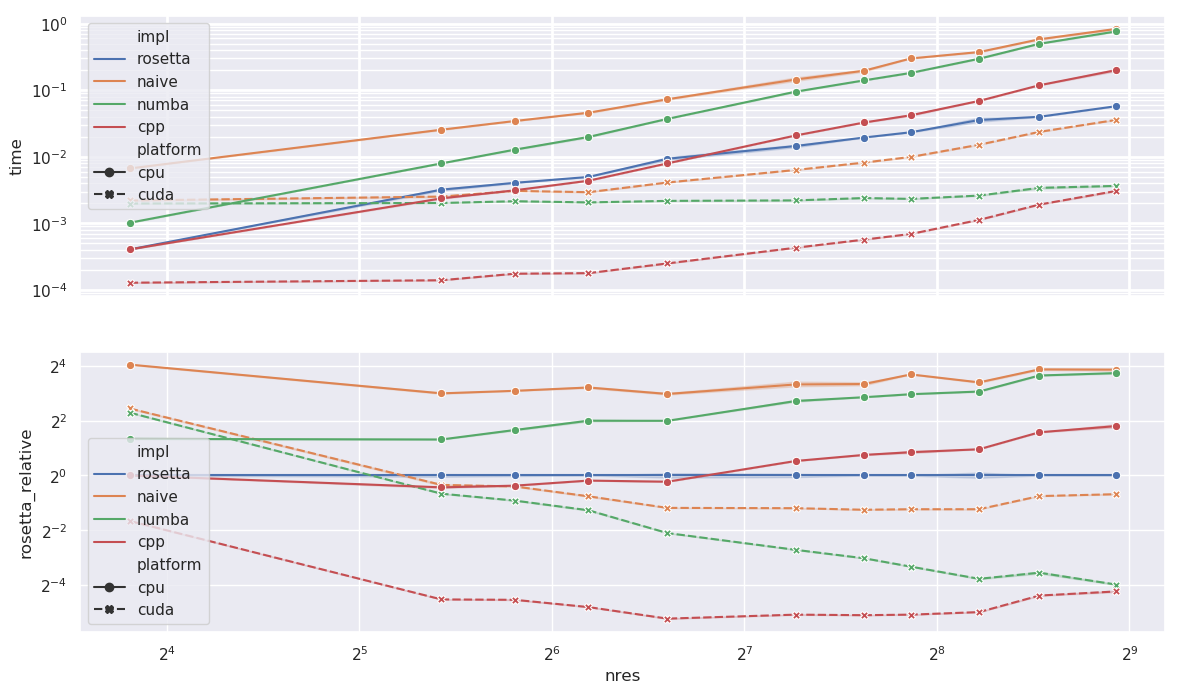

In [18]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="impl", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "rosetta_relative", data=dat, hue="impl", style="platform", markers=True)

In [19]:
display((
    dat.query("name=='score.rosetta_atr_rep'")
    .groupby("nres")[["time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

display((dat
    .groupby(("nres", "name"))[["rosetta_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
))

,mean,max,std
,time,time,time
nres,,,
14,0.000406,0.002592,0.000080
43,0.003203,0.004565,0.000550
56,0.004055,0.006379,0.000377
73,0.004970,0.005124,0.000025
97,0.009315,0.013814,0.001622
154,0.014491,0.019785,0.001997
197,0.019450,0.019960,0.000176
233,0.023320,0.024436,0.000441


mean                        max  \
                              rosetta_relative      time rosetta_relative   
nres name                                                                   
14   score.rosetta_atr_rep            1.000000  0.000406         6.389506   
     score.tmol_lj_cpu_cpp            1.000824  0.000406         2.093176   
     score.tmol_lj_cpu_naive         16.443975  0.006670        19.366837   
     score.tmol_lj_cpu_numba          2.517061  0.001021         8.414750   
     score.tmol_lj_cuda_cpp           0.316201  0.000128         6.974517   
     score.tmol_lj_cuda_naive         5.431137  0.002203         6.781690   
     score.tmol_lj_cuda_numba         4.889319  0.001983         5.586525   
43   score.rosetta_atr_rep            1.000000  0.003203         1.425020   
     score.tmol_lj_cpu_cpp            0.740185  0.002371         1.278870   
     score.tmol_lj_cpu_naive          7.954869  0.025483        10.603122   
     score.tmol_lj_cpu_numba          2.480600  0.007946         2.861376   
     score.tmol_lj_cuda_cpp           0.043603  0.000140         0.057096   
     score.tmol_lj_cuda_naive         0.787125  0.002521         1.103605   
     score.tmol_lj_cuda_numba         0.630636  0.002020         1.518786   
56   score.rosetta_atr_rep            1.000000  0.004055         1.572959   
     score.tmol_lj_cpu_cpp            0.772568  0.003133         0.786576   
     score.tmol_lj_cpu_naive          8.483637  0.034405         8.516492   
     score.tmol_lj_cpu_numba          3.151393  0.012780         5.038076   
     score.tmol_lj_cuda_cpp           0.043165  0.000175         0.621806   
     score.tmol_lj_cuda_naive         0.757017  0.003070         1.298403   
     score.tmol_lj_cuda_numba         0.529580  0.002148         0.884597   
73   score.rosetta_atr_rep            1.000000  0.004970         1.031093   
     score.tmol_lj_cpu_cpp            0.877981  0.004363         0.912411   
     score.tmol_lj_cpu_naive          9.225717  0.045848        11.027314   
     score.tmol_lj_cpu_numba          3.985909  0.019808         6.222452   
     score.tmol_lj_cuda_cpp           0.035935  0.000179         0.057072   
     score.tmol_lj_cuda_naive         0.590578  0.002935         1.119334   
     score.tmol_lj_cuda_numba         0.414877  0.002062         0.815907   
97   score.rosetta_atr_rep            1.000000  0.009315         1.483054   
     score.tmol_lj_cpu_cpp            0.853366  0.007949         0.866084   
...                                        ...       ...              ...   
197  score.tmol_lj_cuda_naive         0.420244  0.008174         0.424399   
     score.tmol_lj_cuda_numba         0.123286  0.002398         0.138573   
233  score.rosetta_atr_rep            1.000000  0.023320         1.047881   
     score.tmol_lj_cpu_cpp            1.797556  0.041919         2.583282   
     score.tmol_lj_cpu_naive         12.839221  0.299409        12.847020   
     score.tmol_lj_cpu_numba          7.786592  0.181582         7.798868   
     score.tmol_lj_cuda_cpp           0.029677  0.000692         0.031605   
     score.tmol_lj_cuda_naive         0.425898  0.009932         0.515512   
     score.tmol_lj_cuda_numba         0.099844  0.002328         0.127511   
298  score.rosetta_atr_rep            1.000000  0.035582         1.431815   
     score.tmol_lj_cpu_cpp            1.937913  0.068954         1.948752   
     score.tmol_lj_cpu_naive         10.500045  0.373609        10.675995   
     score.tmol_lj_cpu_numba          8.331792  0.296459         8.496861   
     score.tmol_lj_cuda_cpp           0.031662  0.001127         0.067023   
     score.tmol_lj_cuda_naive         0.425833  0.015152         0.439315   
     score.tmol_lj_cuda_numba         0.073371  0.002611         0.175889   
370  score.rosetta_atr_rep            1.000000  0.039804         1.010541   
     score.tmol_lj_cpu_cpp            2.974816  0.118410         3.002035   
     score.tmol_lj_cpu_naive         1